In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [45]:
df = pd.read_csv('08notsmote_FEAUTURES.csv')
df.head()

,Appetite,pEffort,Sex_F,SleepInd,SleepInd(-1),SleepInd(-2),uaI,uaI(-1),uaI(-2),pEffort(-1),pEffort(-2),Appetite(-1),Appetite(-2),FatigInd
0,5.0,4.0,1,-4.50,-5.0,-8.0,2.18,2.30,0.00,4.0,1.0,6.0,5.0,Optimal
1,6.0,1.0,1,-6.53,-6.0,-6.0,2.00,2.00,2.00,5.0,6.0,6.0,6.0,Optimal
2,5.0,1.0,0,-4.00,-3.5,-5.0,0.00,0.00,3.00,1.0,1.0,6.0,6.0,Optimal
3,6.0,4.0,1,-6.00,-6.0,-6.0,2.21,2.69,2.51,5.0,6.0,6.0,6.0,Optimal
4,6.0,7.0,1,-5.50,-5.0,-6.0,1.74,2.03,1.80,7.0,8.0,6.0,6.0,Optimal


In [46]:
X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

In [47]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=3265)
X_train.shape, X_test.shape

((516, 13), (129, 13))

In [48]:
# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
# Define the parameter grid
param_distributions = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'splitter': ['best', 'random'],   # Strategy for choosing the split
    'max_depth': [None, 5, 10, 15, 20],  # Depth of the tree
    'min_samples_split': np.arange(2, 21, 2),  # Minimum samples to split
    'min_samples_leaf': np.arange(1, 11),  # Minimum samples per leaf
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider
}
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # Cross-validation folds
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit to the training data
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy')

In [49]:
# Retrieve the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'splitter': 'best', 'min_samples_split': np.int64(18), 'min_samples_leaf': np.int64(8), 'max_features': None, 'max_depth': None, 'criterion': 'gini'}


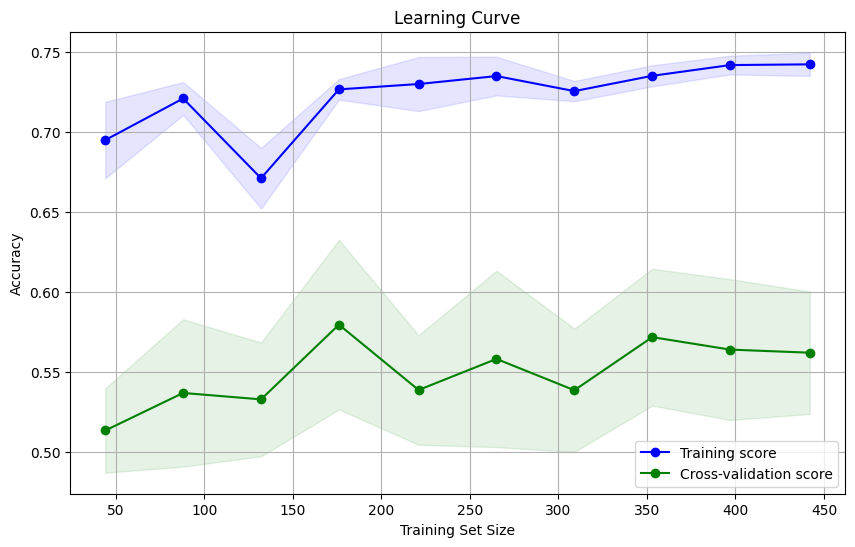

In [50]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1
)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()



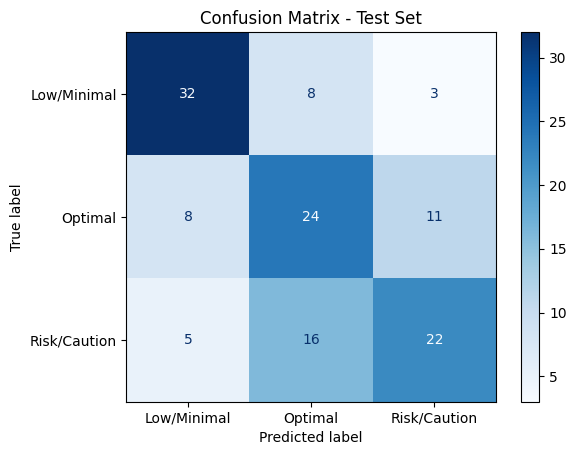

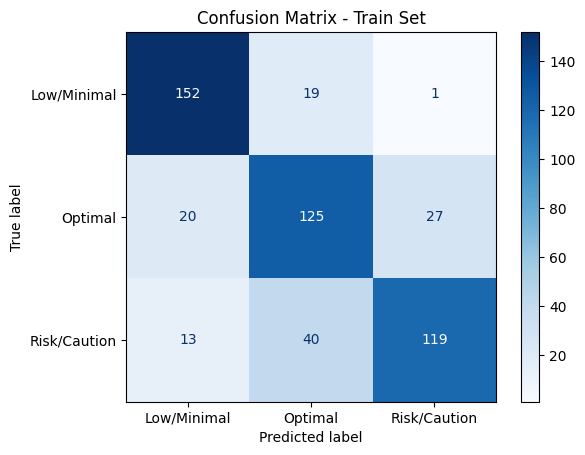

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_model.classes_)
disp_test.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_model.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_model.classes_)
disp_train.plot(cmap="Blues")
plt.title("Confusion Matrix - Train Set")
plt.show()


In [52]:
from sklearn.metrics import classification_report

y_pred_test = best_model.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.71      0.74      0.73        43
     Optimal       0.50      0.56      0.53        43
Risk/Caution       0.61      0.51      0.56        43

    accuracy                           0.60       129
   macro avg       0.61      0.60      0.60       129
weighted avg       0.61      0.60      0.60       129



In [53]:
y_pred_train = best_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.82      0.88      0.85       172
     Optimal       0.68      0.73      0.70       172
Risk/Caution       0.81      0.69      0.75       172

    accuracy                           0.77       516
   macro avg       0.77      0.77      0.77       516
weighted avg       0.77      0.77      0.77       516

